# Phân lớp

## Import thư viện

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import os
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns 
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import time

## Xây dựng Dataset và DataLoader

In [2]:
class ChessPiecesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root_dir, target_class)
            for root, _, fnames in sorted(os.walk(class_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, self.class_to_idx[target_class]
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [3]:
# Data augmentation và transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.RandomGrayscale(p=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Create datasets
train_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chesspieces/ChessPieces_Dataset/train', transform=train_transforms)
val_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chesspieces/ChessPieces_Dataset/val', transform=val_test_transforms)
test_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chesspieces/ChessPieces_Dataset/test', transform=val_test_transforms)


# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Chọn và xây dựng mô hình Resnet50

In [5]:
# Sử dụng pre-trained ResNet
model = models.resnet50(weights=True)

# Thay đổi lớp fully connected cuối cùng
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # 6 lớp quân cờ

# Chuyển mô hình sang GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


## Huấn luyện mô hình

In [6]:
# Định nghĩa hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Huấn luyện
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
patience = 10 # Early stopping patience = 10 epochs
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()  
    since = time.time()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

  
    model.eval()  
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            time_elapsed = time.time() - since
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    

Epoch 1/100, Train Loss: 0.8806, Train Acc: 66.53%, Val Loss: 1.3811, Val Acc: 63.61%
Epoch 2/100, Train Loss: 0.5569, Train Acc: 79.39%, Val Loss: 0.5177, Val Acc: 80.69%
Epoch 3/100, Train Loss: 0.4260, Train Acc: 84.58%, Val Loss: 0.5451, Val Acc: 83.89%
Epoch 4/100, Train Loss: 0.3501, Train Acc: 87.31%, Val Loss: 0.3116, Val Acc: 90.14%
Epoch 5/100, Train Loss: 0.3025, Train Acc: 89.26%, Val Loss: 0.2035, Val Acc: 94.03%
Epoch 6/100, Train Loss: 0.2509, Train Acc: 91.21%, Val Loss: 0.3154, Val Acc: 90.14%
Epoch 7/100, Train Loss: 0.2375, Train Acc: 91.80%, Val Loss: 0.2509, Val Acc: 91.81%
Epoch 8/100, Train Loss: 0.2077, Train Acc: 92.87%, Val Loss: 0.1691, Val Acc: 94.72%
Epoch 9/100, Train Loss: 0.1770, Train Acc: 93.69%, Val Loss: 0.2584, Val Acc: 93.19%
Epoch 10/100, Train Loss: 0.1914, Train Acc: 93.68%, Val Loss: 0.2251, Val Acc: 94.17%
Epoch 11/100, Train Loss: 0.1574, Train Acc: 94.68%, Val Loss: 0.1792, Val Acc: 94.31%
Epoch 12/100, Train Loss: 0.1345, Train Acc: 95.54%,

## Đánh giá mô hình trên tập test

In [7]:
model.eval()  
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy()) 


print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 95.83%


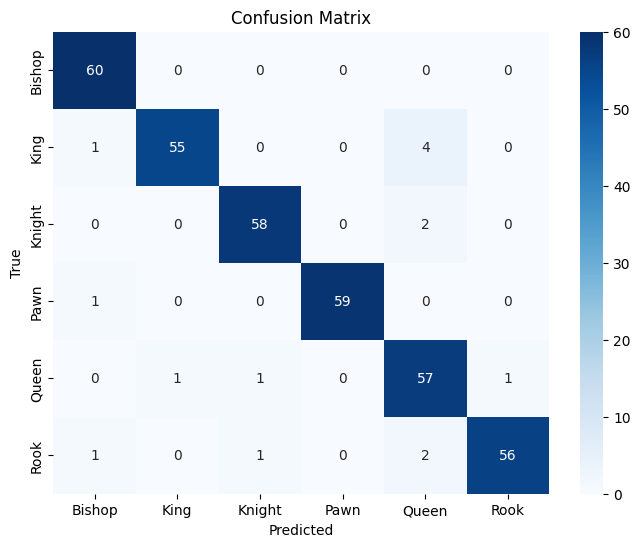

In [8]:
# Confusion matrix 
cm = confusion_matrix(all_labels, all_predictions)
class_names = test_dataset.classes 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

              precision    recall  f1-score   support

      Bishop       0.95      1.00      0.98        60
        King       0.98      0.92      0.95        60
      Knight       0.97      0.97      0.97        60
        Pawn       1.00      0.98      0.99        60
       Queen       0.88      0.95      0.91        60
        Rook       0.98      0.93      0.96        60

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



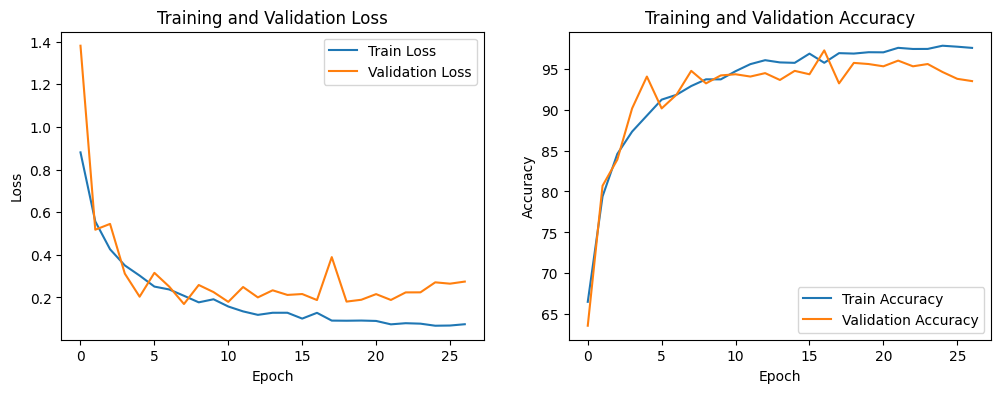

In [10]:
# Vẽ loss và accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Lưu mô hình

In [11]:
torch.save(model.state_dict(), '/kaggle/working/chess_classifier_resnet.pth')

## Load mô hình và dự đoán

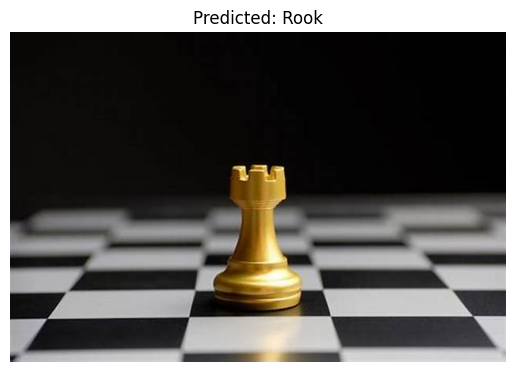

In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import requests  
from io import BytesIO  
import matplotlib.pyplot as plt 


# Load mô hình 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model.load_state_dict(torch.load('/kaggle/input/classifier_resnet_chess_pieces/pytorch/default/1/chess_classifier_resnet.pth', map_location=device, weights_only=True), strict=True) 
model = model.to(device)
model.eval()


def predict_chess_piece(image_path, model):
    try:
        # Tải ảnh từ URL nếu image_path là URL, nếu không thì mở từ đường dẫn local
        if image_path.startswith('http'):
            response = requests.get(image_path, stream=True)
            response.raise_for_status()  # Kiểm tra lỗi HTTP
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        img_tensor = transform(img)
        img_tensor = img_tensor.unsqueeze(0)  
        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output.data, 1)
            class_names = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
            predicted_class_name = class_names[predicted.item()]

        # Hiển thị ảnh
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class_name}')
        plt.axis('off')  
        plt.show()

        return predicted_class_name
    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi tải ảnh từ URL: {e}")
        return None
    except FileNotFoundError:
        print(f"Không tìm thấy file ảnh tại đường dẫn: {image_path}")
        return None
    except Exception as e:
        print(f"Lỗi: {e}")
        return None




# Lấy URL ảnh từ Google 
image_url = "https://th.bing.com/th/id/OIP.WFJWXStgROcAoCjo4h-O_QHaE7?w=626&h=417&rs=1&pid=ImgDetMain"  

# Dự đoán và hiển thị
predicted_piece = predict_chess_piece(image_url, model)

## Fine-tuning model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import os
import time
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [14]:
# Thiết lập device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [15]:
# Data augmentation và transforms (giữ nguyên như khi train)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.RandomGrayscale(p=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
# Tạo datasets 
train_dataset = datasets.ImageFolder(root='/kaggle/input/chesspieces/ChessPieces_Dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='/kaggle/input/chesspieces/ChessPieces_Dataset/val', transform=val_transforms)

# Tạo DataLoaders 
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [17]:
# Load pre-trained ResNet50 
model = models.resnet50(weights=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Unfreeze một số lớp cuối 
for param in model.layer4.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

# Optimizer: Adam, learning rate nhỏ
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

# Learning rate scheduler: ReduceLROnPlateau (giảm lr khi val_loss không cải thiện)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [21]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=25, patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0  # Đếm số epoch không có sự cải thiện

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            data_loader = train_loader if phase == 'train' else val_loader

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)

                # Kiểm tra điều kiện Early Stopping
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0  # Reset bộ đếm nếu có cải thiện
                else:
                    epochs_no_improve += 1  # Tăng bộ đếm nếu không cải thiện

        print()

        # Dừng sớm nếu không có sự cải thiện trong "patience" epoch liên tiếp
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load model tốt nhất
    model.load_state_dict(best_model_wts)
    return model

In [22]:

model_ft = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.3633 Acc: 0.8722
val Loss: 0.1145 Acc: 0.9611

Epoch 2/50
----------
train Loss: 0.1086 Acc: 0.9636
val Loss: 0.1163 Acc: 0.9667

Epoch 3/50
----------
train Loss: 0.0661 Acc: 0.9782
val Loss: 0.1411 Acc: 0.9583

Epoch 4/50
----------
train Loss: 0.0695 Acc: 0.9770
val Loss: 0.1090 Acc: 0.9750

Epoch 5/50
----------
train Loss: 0.0483 Acc: 0.9836
val Loss: 0.1664 Acc: 0.9708

Epoch 6/50
----------
train Loss: 0.0479 Acc: 0.9856
val Loss: 0.1610 Acc: 0.9681

Epoch 7/50
----------
train Loss: 0.0424 Acc: 0.9857
val Loss: 0.1505 Acc: 0.9625

Epoch 8/50
----------
train Loss: 0.0375 Acc: 0.9878
val Loss: 0.1049 Acc: 0.9778

Epoch 9/50
----------
train Loss: 0.0341 Acc: 0.9894
val Loss: 0.1112 Acc: 0.9806

Epoch 10/50
----------
train Loss: 0.0310 Acc: 0.9907
val Loss: 0.1360 Acc: 0.9708

Epoch 11/50
----------
train Loss: 0.0293 Acc: 0.9904
val Loss: 0.1420 Acc: 0.9694

Epoch 12/50
----------
train Loss: 0.0360 Acc: 0.9888
val Loss: 0.1226 Acc: 0.9694

E

## Lưu mô hình sau khi fine-tuning

In [23]:
# Lưu mô hình
torch.save(model_ft.state_dict(), '/kaggle/working/chess_classifier_resnet_finetuned.pth')

## Đánh giá mô hình sau khi fine-tuning

In [24]:
model = models.resnet50(pretrained=False)  # Khởi tạo lại kiến trúc
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model.load_state_dict(torch.load('/kaggle/input/chess_pieces_classifier_finetuned/pytorch/default/1/chess_classifier_resnet_finetuned.pth', map_location=device, weights_only=True), strict=True)
model = model.to(device)
model.eval() 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root='/kaggle/input/chesspieces/ChessPieces_Dataset/test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4) 

In [26]:
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 95.56%


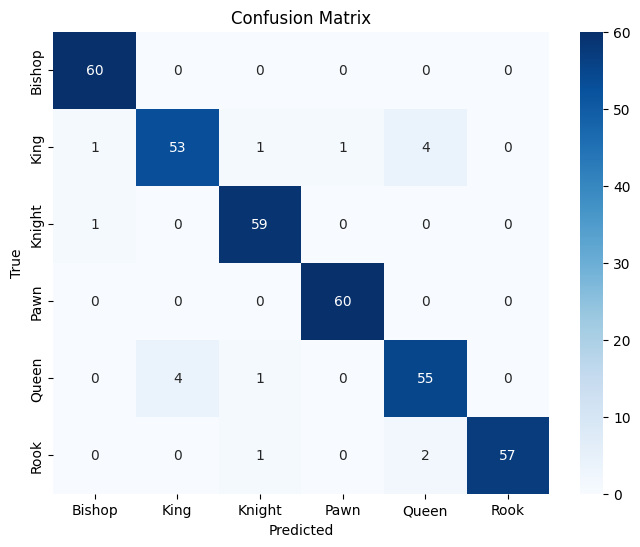

In [27]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)
class_names = test_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

              precision    recall  f1-score   support

      Bishop       0.97      1.00      0.98        60
        King       0.93      0.88      0.91        60
      Knight       0.95      0.98      0.97        60
        Pawn       0.98      1.00      0.99        60
       Queen       0.90      0.92      0.91        60
        Rook       1.00      0.95      0.97        60

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360

